<a href="https://colab.research.google.com/github/SwartBen/rock-paper-scissors-img-classification/blob/main/rps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Rock-Paper-Scissor Image Classification**
Use the game (https://cloudstor.aarnet.edu.au/plus/s/6QNijohkrfMZ0H7) dataset. 

The dataset contains a total of 2188 images corresponding to the 'Rock' (726 images), 'Paper' (710 images) and 'Scissors' (752 images) hand gestures of the Rock-Paper-Scissors game. 

All images are taken on a green background with relatively consistent ligithing and white balance.

All images are RGB images of 300 pixels wide by 200 pixels high in .png format. The images are separated in three sub-folders named 'rock', 'paper' and 'scissors' according to their respective class.

## Import Libraries

In [ ]:
# Importing libraries. 
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load dataset

In [ ]:
# Dataset path.
data_dir = '/content/drive/MyDrive/cv_comp/game'
classes = os.listdir(data_dir)

# Performing Image Transformations.
train_transform=transforms.Compose([
        #transforms.Resize(40),             
        #transforms.CenterCrop(40), 

        transforms.Resize(120),             
        transforms.CenterCrop(120),
        #transforms.RandomHorizontalFlip(0.2),  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
        #transforms.Grayscale()
])

In [ ]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 2188


In [ ]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  paper (0)


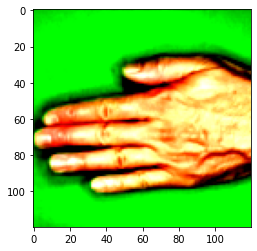

In [ ]:
show_image(*dataset[0])

In [ ]:
# Setting seed so that value won't change everytime. 
# Splitting the dataset to training, validation, and testing category.

torch.manual_seed(10)
val_size = len(dataset)//10
test_size = len(dataset)//5
train_size = len(dataset) - val_size - test_size

In [ ]:
# Random Splitting
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)  

(1533, 218, 437)

In [ ]:
batch_size = 8
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


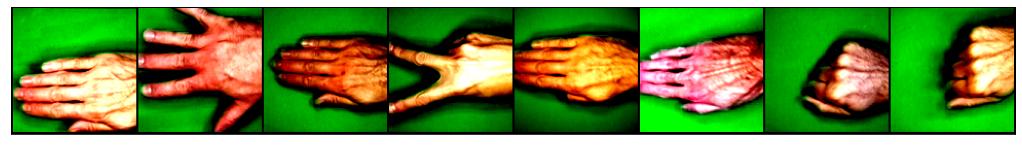

In [ ]:
# Multiple images preview. 
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

## Training helper methods

In [ ]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
# To check wether Google Colab GPU has been assigned/not. 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## Define CNN Model

In [ ]:
class CnnModel(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            nn.Dropout(0.2),

            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(96, 96, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            nn.Dropout(0.2),

            nn.Conv2d(96, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            nn.Dropout(0.2),

            nn.Conv2d(128, 160, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(160),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            nn.Dropout(0.2),

            nn.Conv2d(160, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            nn.Dropout(0.2),

            nn.Flatten(), 
            nn.Linear(128, 32),  
            nn.ReLU(), 
            nn.Dropout(0.2),

            nn.Linear(32, 8),           
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(8, self.classes))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
num_classes = 3
model = CnnModel(num_classes).cuda()

In [ ]:
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)    
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([8, 3, 120, 120])
out.shape: torch.Size([8, 3])
out[0]: tensor([ 0.4172, -0.2849,  0.5050], device='cuda:0', grad_fn=<SelectBackward0>)


In [ ]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)
to_device(model, device)

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.2, inplace=False)
    (11): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): MaxPool2d(kernel_size

## Run model

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.0005

In [ ]:
model = CnnModel(num_classes).cuda()
history = [evaluate(model, val_loader)]
history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/192 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.7032, val_loss: 0.3659, val_acc: 0.9375


  0%|          | 0/192 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.3338, val_loss: 0.1292, val_acc: 0.9598


  0%|          | 0/192 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.2643, val_loss: 0.0893, val_acc: 0.9732


  0%|          | 0/192 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.1926, val_loss: 0.0828, val_acc: 0.9732


  0%|          | 0/192 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.1568, val_loss: 0.0513, val_acc: 0.9866


  0%|          | 0/192 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.1362, val_loss: 0.0469, val_acc: 0.9821


  0%|          | 0/192 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.1259, val_loss: 0.1064, val_acc: 0.9643


  0%|          | 0/192 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.1311, val_loss: 0.0505, val_acc: 0.9866


  0%|          | 0/192 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.1384, val_loss: 0.5150, val_acc: 0.8420


  0%|          | 0/192 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.1149, val_loss: 0.0649, val_acc: 0.9732


## Evaluate model - accuracy and loss

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

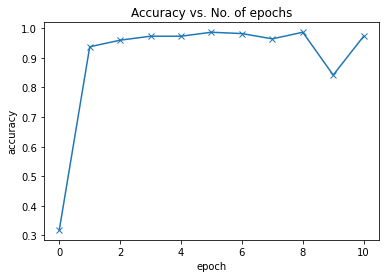

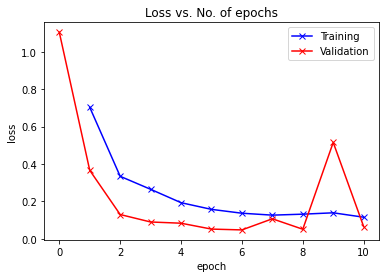

In [ ]:
plot_accuracies(history)
plot_losses(history)

In [ ]:
print(evaluate(model, test_loader))

{'val_loss': 0.05450066924095154, 'val_acc': 0.9821428656578064}


##FLOPs

In [ ]:
# Code from https://cloudstor.aarnet.edu.au/plus/s/PcSc67ZncTSQP0E can be used to count flops
!wget -c https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
!mv download FLOPs_counter.py

--2022-06-27 02:26:39--  https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
Resolving cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)... 202.158.207.20
Connecting to cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)|202.158.207.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: 5230042dc1897=e53nriitaeeveugh308bamastm; path=/plus;; Secure at position 53.
Syntax error in Set-Cookie: oc_sessionPassphrase=vAtd%2FnFUmc5HD%2FtpaAtzr%2BiwB%2B8i1J0KU7OnX9OctE8viCs63rC7J9%2Fdqg4VeofIicb2BmoeUg1XJtlBz5Qtxt0MNV%2F6%2BqIsFEfBQzFAsm57v%2Bo4UqbbtYVbp6rhVCKm; path=/plus;; Secure at position 178.
Length: 5201 (5.1K) [text/x-python]
Saving to: ‘download’

download            100%[===================>]   5.08K  --.-KB/s    in 0s      

2022-06-27 02:26:41 (480 MB/s) - ‘download’ saved [5201/5201]



In [ ]:
from FLOPs_counter import print_model_parm_flops

# Input size should be the same as the img size put into the model 
input = torch.randn(1, 3, 120, 120) 

# Get the network and its FLOPs
num_classes = 3
model = CnnModel(num_classes)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 0.81G
